
## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img2 = cv2.imread(fname)
    gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
    
    # Save shape
    shape = gray.shape

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img2 = cv2.drawChessboardCorners(img2, (9,6), corners, ret)

# save image
cv2.imwrite('../submission/uncorr.jpg', img2)


True

In [3]:
test_images = glob.glob('../test_images/*.jpg')
# calibrate camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)
# thresholds
color_thresh=(170, 255)
sobel_thresh=(20, 100)
# choose one image
img = test_images[1]
## loop on raw images#

# read image
test_image = cv2.imread(img)
# save image
cv2.imwrite('../submission/test_image.jpg', test_image)
# Generate x and y values for plotting
ploty = np.linspace(0, test_image.shape[0]-1, test_image.shape[0] )

## Define auxillary and pipeline functions

### Undistort

In [4]:
def undistort(test_image, mtx, dist):
    # undist image
    test_image_undist = cv2.undistort(test_image, mtx, dist, None, mtx)
    return test_image_undist

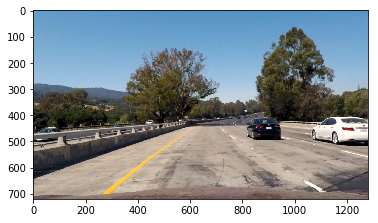

In [5]:
# save image
#for img in test_images:
undistorted2 = undistort(img2, mtx, dist)
cv2.imwrite('../submission/corr.jpg', undistorted2)
undistorted = undistort(test_image, mtx, dist)
cv2.imwrite('../submission/undistorted.jpg', undistorted)
plt.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))

### Sobel

In [6]:
def xgradient(test_image):
    # Sobel operator in x
    gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sobel_thresh[0]) & (scaled_sobel <= sobel_thresh[1])] = 1
    return sxbinary

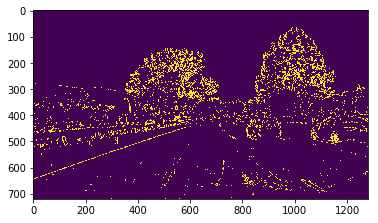

In [7]:
test_image_undist = undistort(test_image, mtx, dist)
# save image
xgrad_img = xgradient(test_image_undist)
cv2.imwrite('../submission/xgrad_img.jpg', xgrad_img)
plt.imshow(xgrad_img)

### Color

In [8]:
def colorthreshold(test_image):
    # Threshold color channel    
    # convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(test_image, cv2.COLOR_BGR2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= color_thresh[0]) & (s_channel <= color_thresh[1])] = 1
    return s_binary

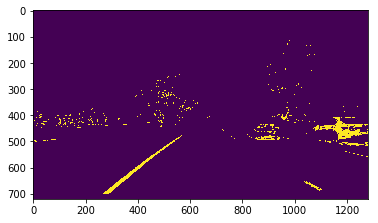

In [9]:
test_image_undist = undistort(test_image, mtx, dist)
# save image
xgrad_img = xgradient(test_image_undist)
col_thre_img = colorthreshold(test_image_undist)
cv2.imwrite('../submission/col_thre_img.jpg', col_thre_img)
plt.imshow(col_thre_img)

### Combine

In [10]:
def combinefilters(test_image_sobel, test_image_colthre):
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(test_image_sobel)
    combined_binary[(test_image_sobel == 1) | (test_image_colthre == 1)] = 1
    combined_binary = combined_binary * 255
    return combined_binary


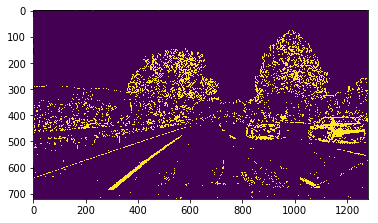

In [11]:
im_xgrad = xgradient(test_image)
im_col = colorthreshold(test_image)
combined_filts = combinefilters(im_xgrad, im_col)
cv2.imwrite('../submission/combined_filts.jpg', combined_filts)
plt.imshow(combined_filts)

### Perspective

In [12]:
def perspective(combined_binary):
    # Choose source points and get perspective transform
    # Perspective transform
    src = np.array([[combined_binary.shape[1],combined_binary.shape[0]-10], # col, row
                    [0,combined_binary.shape[0]-10],
                    [546,460],
                    [732,460]],
                   np.float32)
    dst = np.array([[combined_binary.shape[1],combined_binary.shape[0]], # col, row
                    [0,combined_binary.shape[0]],
                    [0,0],
                    [combined_binary.shape[1],0]],
                   np.float32)
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform( src, dst)
    # Calculate inverse perspective transform
    Minv = cv2.getPerspectiveTransform( dst, src)    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(combined_binary, M, (combined_binary.shape[1],combined_binary.shape[0]))
    return warped, Minv

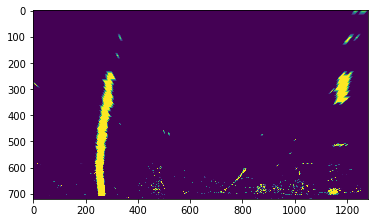

In [13]:
im_fil = combinefilters(im_xgrad, im_col)
per,_ = perspective(im_fil)
cv2.imwrite('../submission/per.jpg', per)
plt.imshow(per)

### Histogram

In [14]:
def histogram_f(image):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
    return histogram

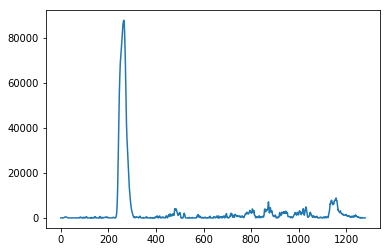

In [15]:
plt.plot(histogram_f(per))

### lane pixels

In [16]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = histogram_f(binary_warped)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 4000

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        print('except')
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


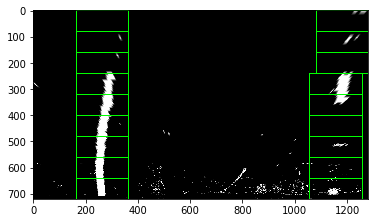

In [17]:
leftx, lefty, rightx, righty, im_pix = find_lane_pixels(per)
cv2.imwrite('../submission/find_lane_pixels.jpg', im_pix)
plt.imshow(im_pix)

### sanity checking funs

In [18]:
def similar_curv(l1, l2):
    c0 = np.abs(l1[0]-l2[0]) < 0.01
    c1 = np.abs(l1[1]-l2[1]) < 0.1
    return c0 and c1

### fit poly

In [19]:
def fit_polynomial(binary_warped, leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    return out_img, left_fit, right_fit, left_fitx, right_fitx


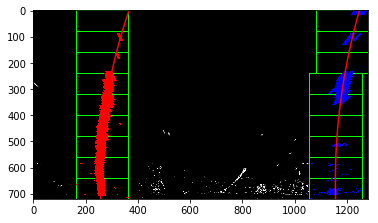

In [20]:
# Find our lane pixels first
leftx, lefty, rightx, righty, out_img = find_lane_pixels(per)
_, left_fit, right_fit, left_fitx, right_fitx  = fit_polynomial(out_img, leftx, lefty, rightx, righty)
# Plots the left and right polynomials on the lane lines
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='red')
plt.plot(right_fitx, ploty, color='red')

### Search around line

In [39]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    no_poly = False
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        no_poly = True
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty    
    return left_fitx, right_fitx, no_poly, left_fit, right_fit

In [40]:
def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit new polynomials
    left_fitx, right_fitx, no_poly, left_fit, right_fit = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    if no_poly == False:
        ## Visualization ##
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    return result, left_fitx, right_fitx, no_poly, left_fit, right_fit

True

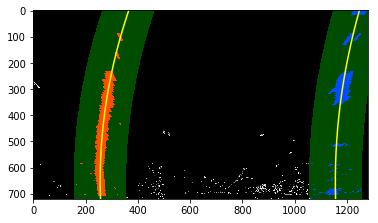

In [42]:
leftx, lefty, rightx, righty, out_img = find_lane_pixels(per)
poly, left_fit, right_fit, left_fitx, right_fitx= fit_polynomial(per, leftx, lefty, rightx, righty)
result, left_fitx, right_fitx, _, _, _ = search_around_poly(per,left_fit, right_fit)
# Plots the left and right polynomials on the lane lines
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
cv2.imwrite('../submission/search_around.jpg', result)

### Measure curvature

In [43]:
def measure_curvature_real(ploty,left_fitx, right_fitx, ym_per_pix, xm_per_pix):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    leftx = left_fitx[::-1]  # Reverse to match top-to-bottom in y
    rightx = right_fitx[::-1]  # Reverse to match top-to-bottom in y
    # Fit a second order polynomial to pixel positions in each fake lane line
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
        # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    return left_curverad, right_curverad

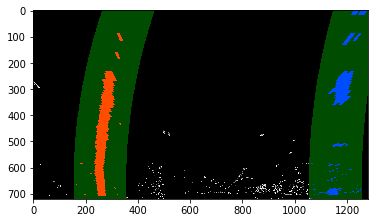

In [45]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
leftx, lefty, rightx, righty, out_img = find_lane_pixels(per)
poly, left_fit, right_fit, left_fitx, right_fitx = fit_polynomial(per, leftx, lefty, rightx, righty)
result, left_fitx2, right_fitx2, _ , _, _= search_around_poly(per,left_fit, right_fit)
plt.imshow(result)
left_curve, right_curve = measure_curvature_real(ploty, left_fitx2, right_fitx2, ym_per_pix, xm_per_pix)    

### Line class

In [46]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, n=3):
        self.n = n
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')         
        # horizontal distance
        self.horizontal_distance = None
        
        #container for last n best_fit
        self.best_fit_n = []  
        #container for last n recent_xfitted
        self.recent_xfitted_n = []
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = []  
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  
        
    def update_for_smooth(self, best_fit, recent_xfitted):
        self.best_fit_n.append(best_fit)        
        self.recent_xfitted_n.append(recent_xfitted)
        
        if len(self.best_fit_n) == self.n:
            self.best_fit = np.mean(np.asarray(self.best_fit_n), axis=0)
            self.best_fit_n = [self.best_fit]
            self.recent_xfitted = np.mean(np.asarray(self.recent_xfitted_n), axis=0)
            self.recent_xfitted_n = [self.recent_xfitted]            
        else:
            self.best_fit = best_fit
            self.recent_xfitted = recent_xfitted
            

### Vehicle center

In [47]:
def get_vehicle_offset_from_center(left_line_pos, right_line_pos, car_center):
    offset = car_center - ((left_line_pos + right_line_pos) / 2)
    return offset

### Sanity checking functions

### Draw on image

In [48]:
def draw(original, warped, left_fitx, right_fitx, ploty, Minv, left_roc, right_roc, off):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the image
    cv2.fillPoly(color_warp, np.int_([pts_left]), (255,0, 0),8,14)
    cv2.fillPoly(color_warp, np.int_([pts_right]), (0,255,0),8,14)
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(original, 1, newwarp, 0.3, 0)
    l_roc = 'left roc =' + str(np.int(left_roc))
    r_roc = 'right roc =' + str(np.int(right_roc))
    off = 'offset =' + str(np.around(off,3))
    cv2.putText(result, l_roc, (10,50), cv2.FONT_HERSHEY_SIMPLEX,2, (0,255,0),4)
    cv2.putText(result, r_roc, (600,50), cv2.FONT_HERSHEY_SIMPLEX,2, (0, 255,0),4)
    cv2.putText(result, off, (10,100), cv2.FONT_HERSHEY_SIMPLEX,2, (0,255,0),4)
    
    return result

### Run pipeline

In [54]:
def pipeline(test_image, ym_per_pix = 30/720, xm_per_pix = 3.7/700):
    '''
    run series of image function 
    '''
    # run toolchain #
    test_image_undist = undistort(test_image, mtx, dist)
    test_image_xgrad = xgradient(test_image_undist)
    test_image_colthre = colorthreshold(test_image_undist)
    test_image_filtered = combinefilters(test_image_xgrad, test_image_colthre)
    test_image_filtered_per,Minv = perspective(test_image_filtered)
    ###

    # choose algorithm based on previous detection #
    if left_line.detected and right_line.detected:
        _, left_line.recent_xfitted, right_line.recent_xfitted, no_poly, left_line.best_fit, right_line.best_fit = \
        search_around_poly(test_image_filtered_per,left_line.best_fit, right_line.best_fit)
        if no_poly == True:
            left_line.allx, left_line.ally, right_line.allx, right_line.ally, _ = \
            find_lane_pixels(test_image_filtered_per)
            _, left_line.best_fit, right_line.best_fit, left_line.recent_xfitted, right_line.recent_xfitted = \
            fit_polynomial(test_image_filtered_per,left_line.allx, left_line.ally,right_line.allx, right_line.ally)
            ### correct for pixel to meter conversion
            ym_per_pix = 30/(right_line.best_fit[2] - left_line.best_fit[2])
            left_line.detected = True
            right_line.detected = True
    else: 
        left_line.allx, left_line.ally, right_line.allx, right_line.ally, _ = \
        find_lane_pixels(test_image_filtered_per)
        _, left_line.best_fit, right_line.best_fit, left_line.recent_xfitted, right_line.recent_xfitted = \
        fit_polynomial(test_image_filtered_per,left_line.allx, left_line.ally,right_line.allx, right_line.ally)
        ### correct for pixel to meter conversion
        ym_per_pix = 30/(right_line.best_fit[2] - left_line.best_fit[2])
        left_line.detected = True
        right_line.detected = True 
        ###
    ###


    # smooth line #
    left_line.update_for_smooth(left_line.best_fit, left_line.recent_xfitted)
    right_line.update_for_smooth(right_line.best_fit, right_line.recent_xfitted)    
    ###
    
    # measure curvature and find offset #
    left_line.radius_of_curvature, right_line.radius_of_curvature = measure_curvature_real(ploty,
                                                                                           left_line.recent_xfitted,
                                                                                           right_line.recent_xfitted,
                                                                                           ym_per_pix, xm_per_pix)  
    vehicle_offset = get_vehicle_offset_from_center(left_line.best_fit[2]*xm_per_pix,
                                   right_line.best_fit[2]*xm_per_pix,
                                   (test_image.shape[1]/2)*xm_per_pix)
    ###

    # draw #
    final = draw(test_image, test_image_filtered_per,
                 left_line.recent_xfitted,
                 right_line.recent_xfitted, ploty, Minv,
                left_line.radius_of_curvature, right_line.radius_of_curvature,
                vehicle_offset)
    ###
    
    return final

### Run on test image

True

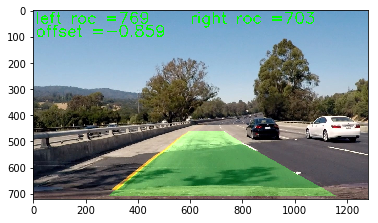

In [55]:
test_images = glob.glob('../test_images/*.jpg')
# calibrate camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)
# thresholds
color_thresh=(170, 255)
sobel_thresh=(20, 100)
# choose one image
img = test_images[7]
# read image
test_image = cv2.imread(img)

# create line objects
left_line = Line() 
right_line = Line() 
# Generate x and y values for plotting
ploty = np.linspace(0, test_image.shape[0]-1, test_image.shape[0] )

# # call fun
final = pipeline(test_image)

# print(similar_curv(left_line.best_fit, right_line.best_fit))
# print(dist = horiz_dist(right_line.best_fit[2]*xm_per_pix,
#                   left_line.best_fit[2]*xm_per_pix))

plt.imshow(cv2.cvtColor(final, cv2.COLOR_BGR2RGB))
cv2.imwrite('../submission/res_test.jpg', final)

### save test images

In [56]:
import os, time
test_images_dir = ('../test_images/')
out_images_dir = ('../output_images/')
# calibrate camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)
# thresholds
color_thresh=(170, 255)
sobel_thresh=(20, 100)
# create line objects
left_line = Line() 
right_line = Line()
# run on all test images
for img in os.listdir(test_images_dir):  
    # read image
    test_image = cv2.imread(test_images_dir + img)
    # Generate x and y values for plotting
    ploty = np.linspace(0, test_image.shape[0]-1, test_image.shape[0] )
    # call pipeline function
    final = pipeline(test_image)
    # save image
    cv2.imwrite(out_images_dir + img, final)

### run on video

In [57]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### project video

In [58]:
white_output = '../project_video_out.mp4'
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video ../project_video_out.mp4
[MoviePy] Writing video ../project_video_out.mp4


100%|█████████▉| 1260/1261 [04:26<00:00,  4.70it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../project_video_out.mp4 

CPU times: user 2min 2s, sys: 18.5 s, total: 2min 20s
Wall time: 4min 30s


### challenge video

In [79]:
white_output = '../challenge_video_out.mp4'
clip1 = VideoFileClip("../challenge_video.mp4").subclip(0,8)
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video ../challenge_video_out.mp4
[MoviePy] Writing video ../challenge_video_out.mp4


100%|██████████| 240/240 [00:45<00:00,  4.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../challenge_video_out.mp4 

CPU times: user 21.3 s, sys: 2.72 s, total: 24 s
Wall time: 49.1 s
